# **Import and Download module**

In [1]:
!wget https://github.com/Natthapolmnc/BertSentimentAnalysis/raw/main/data_set/reviews_Musical_Instruments_5.json.gz

--2022-12-26 07:30:31--  https://github.com/Natthapolmnc/BertSentimentAnalysis/raw/main/data_set/reviews_Musical_Instruments_5.json.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Natthapolmnc/BertSentimentAnalysis/main/data_set/reviews_Musical_Instruments_5.json.gz [following]
--2022-12-26 07:30:31--  https://raw.githubusercontent.com/Natthapolmnc/BertSentimentAnalysis/main/data_set/reviews_Musical_Instruments_5.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2460495 (2.3M) [application/octet-stream]
Saving to: ‘reviews_Musical_Instruments_5.json.gz’

reviews_Musical_Ins 100%[===

In [2]:
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 27.4 MB/s 


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 9.7 MB/s 
     |████████████████████████████████| 182 kB 74.8 MB/s 


In [4]:
import pandas as pd
import os
import pickle as pkl
import numpy as np
import gzip
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

In [5]:
encoder = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# **Bert data-prep**

In [6]:
np.random.seed(42)

In [7]:
def StratifiedSplit(dat,label_name,split_ratio):
  total_row=dat.count()[0]
  labels=dat[label_name].unique()
  ratio_dict={}
  for i in labels:
    ratio_dict[i]=dat.where(dat[label_name]==i).dropna().count()[0]/total_row
  num_sample=int(total_row*split_ratio)
  test_df=pd.DataFrame(columns=dat.columns)
  train_df=pd.DataFrame(columns=dat.columns)
  for i in labels:
    num_sample_label =int(num_sample*ratio_dict[i])
    dat_sm=dat.where(dat[label_name]==i).dropna()
    dat_sm=dat_sm.sample(frac=1)
    msk = np.random.rand(dat_sm.count()[0]) < (num_sample_label/dat_sm.count()[0])
    test_df=test_df.append(dat_sm[msk])
    train_df=train_df.append(dat_sm[~msk])
  return (train_df, test_df)

In [8]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/reviews_Musical_Instruments_5.json.gz')
df = df[['reviewText','overall']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10261 entries, 0 to 10260
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  10261 non-null  object 
 1   overall     10261 non-null  float64
dtypes: float64(1), object(1)
memory usage: 240.5+ KB


In [10]:
max_seq=500
min_seq=50

In [11]:
def splitSentiment(x):
  if x<3:
    return 0
  elif x==3:
    return 1
  elif x>3:
    return 2

In [12]:
df=df[(df['reviewText'].apply(lambda x: x.split()).apply(lambda x:len(x))<max_seq) & (df['reviewText'].apply(lambda x: x.split()).apply(lambda x:len(x))>min_seq)]

In [13]:
good = df[df['overall']>=4]
neutral = df[df['overall']==3]
bad = df[df['overall']<=2]
_min = min(good.shape[0],neutral.shape[0],bad.shape[0])
good = good.sample(n=_min)
neutral = neutral.sample(n=_min)
bad = bad.sample(n=_min)
df = pd.concat([good,neutral,bad])
df = df.sample(frac=1)

In [14]:
df["overall"]=df["overall"].apply(splitSentiment)

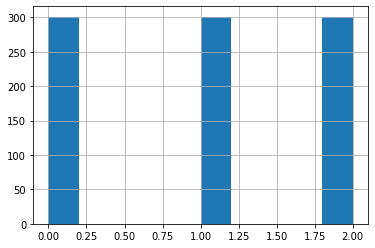

In [15]:
df["overall"].hist()

In [16]:
train_, test_=StratifiedSplit(df,"overall",0.2)

In [17]:
### LOAD BERT TOKENIZERS ###
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [18]:
train_

,reviewText,overall
3425,I was hoping the Lemon oil would be what I nee...,1.0
4818,Behringer makes quality products - I purchased...,1.0
2039,I used this on the side of a wooden bookshelf ...,1.0
8283,I've owned four of these over the past two yea...,1.0
5709,I was looking for an Overdrive or Distortion p...,1.0
...,...,...
7206,So i decided to amplify my Martin Dreadnaught ...,2.0
9422,The product is here and I am glad the size is ...,2.0
5423,Im using this with five pedals and it works gr...,2.0
1107,I bought this mic after hearing good things ab...,2.0


In [19]:
x_ids_tr=[tokenizer.encode(i).ids for i in train_["reviewText"]]
x_ids_tr=pad_sequences(x_ids_tr,maxlen=max_seq,padding="post")
x_msk_tr=[tokenizer.encode(i).attention_mask for i in train_["reviewText"]]
x_msk_tr=pad_sequences(x_msk_tr,maxlen=max_seq,padding="post")
y_tr=to_categorical(train_["overall"].values)

In [20]:
train_["overall"]

3425    1.0
4818    1.0
2039    1.0
8283    1.0
5709    1.0
       ... 
7206    2.0
9422    2.0
5423    2.0
1107    2.0
7942    2.0
Name: overall, Length: 732, dtype: float64

In [21]:
x_ids_t=[tokenizer.encode(i).ids for i in test_["reviewText"]]
x_ids_t=pad_sequences(x_ids_t,maxlen=max_seq,padding="post")
x_msk_t=[tokenizer.encode(i).attention_mask for i in test_["reviewText"]]
x_msk_t=pad_sequences(x_msk_t,maxlen=max_seq,padding="post")
y_t=to_categorical(test_["overall"].values)

# **BERT Model**

In [22]:
#Bert
input_ids = tf.keras.layers.Input(shape=(max_seq,), dtype=tf.int32)
attn_mask = tf.keras.layers.Input(shape=(max_seq,), dtype=tf.int32)
## CLS=1 All word emb=0
wrd_embedding = encoder(input_ids, attention_mask=attn_mask)[1]

drop=tf.keras.layers.Dropout(0.8)(wrd_embedding)
res=tf.keras.layers.Dense(8,activation="relu")(drop)
res2=tf.keras.layers.Dense(8,activation="relu")(res)

### Result Dense
res3=tf.keras.layers.Dense(3,activation="softmax")(res2)

In [23]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=3,
        verbose=1,
    )
]

In [24]:
model=tf.keras.Model(inputs=[input_ids,attn_mask] ,outputs=res3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 500,                                           

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])

In [26]:
x_ids_tr

array([[  101,  1045,  2001, ...,     0,     0,     0],
       [  101,  2022, 26378, ...,     0,     0,     0],
       [  101,  1045,  2109, ...,     0,     0,     0],
       ...,
       [  101, 10047,  2478, ...,     0,     0,     0],
       [  101,  1045,  4149, ...,     0,     0,     0],
       [  101,  2307, 23025, ...,     0,     0,     0]], dtype=int32)

In [27]:
history=model.fit(x=[x_ids_tr,x_msk_tr],y=y_tr,epochs=10,validation_data=([x_ids_t,x_msk_t],y_t),verbose=1,batch_size=8,callbacks=callbacks)

Epoch 1/10
 7/92 [=>............................] - ETA: 1:19 - loss: 1.4237 - accuracy: 0.2679

KeyboardInterrupt: ignored